# Mean-Reversion
This is a backtest of the following strategy:
Buy Nifty50 stock index when 3 day MA is at 5th percentile and sell when that same is at 80th percentile.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
from datetime import date
sb.set()


from matplotlib import rcParams
rcParams['figure.figsize'] = 16,12 #to set figure size

In [2]:
today = str(date.today())

In [3]:
year=int(today[:4])
year-=5
five_years_ago= str(year) + today[4:]
five_years_ago

'2016-10-11'

In [4]:
df = yf.download('^NSEI', 
                  start=five_years_ago, 
                  end=today, 
                  progress=False,
                )
df= df.drop('Open', axis=1)
df= df.drop('High', axis=1)
df= df.drop('Low', axis=1)
df= df.drop('Adj Close', axis=1)
df= df.drop('Volume', axis=1)
df

,Close
Date,
2016-10-13,8573.349609
2016-10-14,8583.400391
2016-10-17,8520.400391
2016-10-18,8677.900391
2016-10-19,8659.099609
...,...
2021-10-04,17691.250000
2021-10-05,17822.300781
2021-10-06,17646.000000


In [5]:

df['returns'] = df['Close'].diff()
df['dummy'] = df['Close'].shift(1)
df['returns']=(df['returns']/df['dummy'])
df=df.drop('dummy',axis=1)
df

,Close,returns
Date,,
2016-10-13,8573.349609,NaN
2016-10-14,8583.400391,0.001172
2016-10-17,8520.400391,-0.007340
2016-10-18,8677.900391,0.018485
2016-10-19,8659.099609,-0.002167
...,...,...
2021-10-04,17691.250000,0.009080
2021-10-05,17822.300781,0.007408
2021-10-06,17646.000000,-0.009892


In [6]:
df['ma']= df['Close'].rolling(21).mean()
df

,Close,returns,ma
Date,,,
2016-10-13,8573.349609,NaN,NaN
2016-10-14,8583.400391,0.001172,NaN
2016-10-17,8520.400391,-0.007340,NaN
2016-10-18,8677.900391,0.018485,NaN
2016-10-19,8659.099609,-0.002167,NaN
...,...,...,...
2021-10-04,17691.250000,0.009080,17552.085751
2021-10-05,17822.300781,0.007408,17575.833426
2021-10-06,17646.000000,-0.009892,17588.604818


In [7]:
df['ratio']=df['Close']/df['ma']
df

,Close,returns,ma,ratio
Date,,,,
2016-10-13,8573.349609,NaN,NaN,NaN
2016-10-14,8583.400391,0.001172,NaN,NaN
2016-10-17,8520.400391,-0.007340,NaN,NaN
2016-10-18,8677.900391,0.018485,NaN,NaN
2016-10-19,8659.099609,-0.002167,NaN,NaN
...,...,...,...,...
2021-10-04,17691.250000,0.009080,17552.085751,1.007929
2021-10-05,17822.300781,0.007408,17575.833426,1.014023
2021-10-06,17646.000000,-0.009892,17588.604818,1.003263


# Getting required percentiles after testing multiple values and choosing best option

After testing multiple values, the 5th and 80th percentile seemed to capture 
most of the action

In [8]:
x=df.quantile(0.05)
p1=x['ratio'] #5th Percentile

y=df.quantile(0.8)
p2=y['ratio'] #80th Percentile

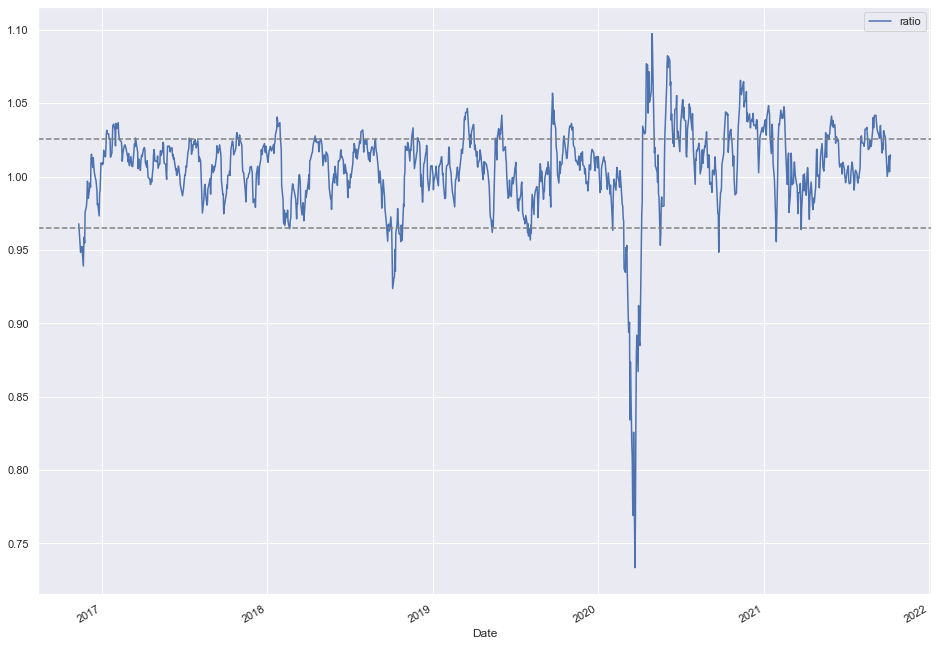

In [9]:
df['ratio'].dropna().plot(legend = True)
plt.axhline(p1, c= (.5,.5,.5), ls='--')
plt.axhline(p2, c= (.5,.5,.5), ls='--')

In [10]:
short = p2
long = p1
df['position'] = np.where(df.ratio > short,-1, np.nan)
df['position'] = np.where(df.ratio < long, 1, df['position'])
df['position'] = df['position'].ffill()

In [11]:
df

,Close,returns,ma,ratio,position
Date,,,,,
2016-10-13,8573.349609,NaN,NaN,NaN,NaN
2016-10-14,8583.400391,0.001172,NaN,NaN,NaN
2016-10-17,8520.400391,-0.007340,NaN,NaN,NaN
2016-10-18,8677.900391,0.018485,NaN,NaN,NaN
2016-10-19,8659.099609,-0.002167,NaN,NaN,NaN
...,...,...,...,...,...
2021-10-04,17691.250000,0.009080,17552.085751,1.007929,-1.0
2021-10-05,17822.300781,0.007408,17575.833426,1.014023,-1.0
2021-10-06,17646.000000,-0.009892,17588.604818,1.003263,-1.0


<AxesSubplot:xlabel='Date'>

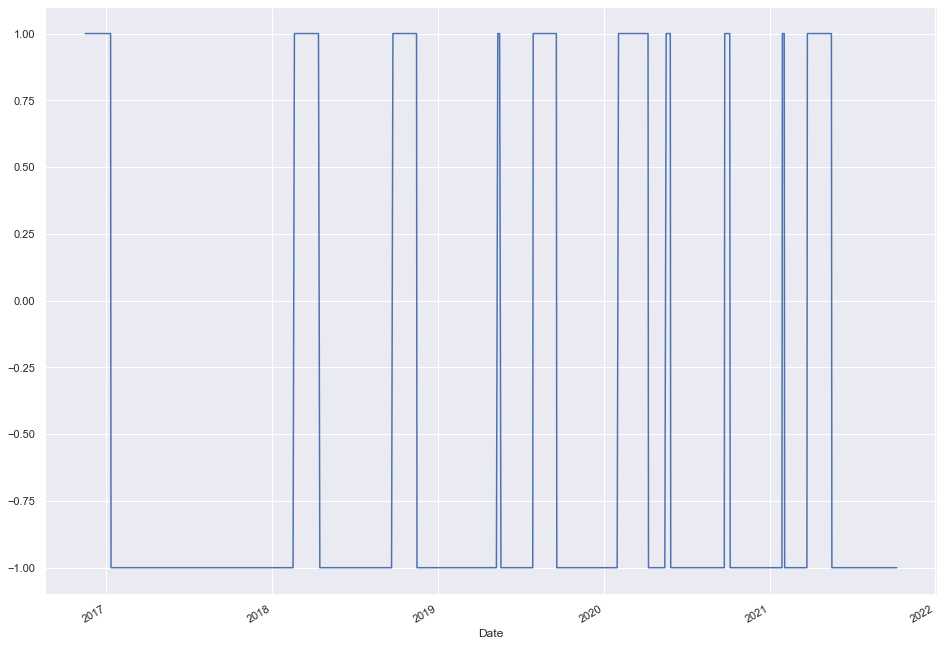

In [12]:
df.position.plot()

In [13]:
df['strat_return'] = df['returns'] * df['position'].shift(1)
df

,Close,returns,ma,ratio,position,strat_return
Date,,,,,,
2016-10-13,8573.349609,NaN,NaN,NaN,NaN,NaN
2016-10-14,8583.400391,0.001172,NaN,NaN,NaN,NaN
2016-10-17,8520.400391,-0.007340,NaN,NaN,NaN,NaN
2016-10-18,8677.900391,0.018485,NaN,NaN,NaN,NaN
2016-10-19,8659.099609,-0.002167,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-10-04,17691.250000,0.009080,17552.085751,1.007929,-1.0,-0.009080
2021-10-05,17822.300781,0.007408,17575.833426,1.014023,-1.0,-0.007408
2021-10-06,17646.000000,-0.009892,17588.604818,1.003263,-1.0,0.009892


In [14]:
Close=df['Close']
strat_return=df['strat_return']
currentValue=10
loc=-1
for i in range(0,len(strat_return),1):
    if(np.isnan(strat_return[i])):
        continue
    
    currentValue=Close[i-1]
    loc=i
    break

currentValue

8108.4501953125

In [15]:
arr=[]
for i in strat_return:
    if(np.isnan(i)):
        arr.append(np.nan)
        continue
    currentValue=currentValue + (currentValue*i)
    arr.append(currentValue)

df['returns(strategy)']=arr
df

,Close,returns,ma,ratio,position,strat_return,returns(strategy)
Date,,,,,,,
2016-10-13,8573.349609,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-14,8583.400391,0.001172,NaN,NaN,NaN,NaN,NaN
2016-10-17,8520.400391,-0.007340,NaN,NaN,NaN,NaN,NaN
2016-10-18,8677.900391,0.018485,NaN,NaN,NaN,NaN,NaN
2016-10-19,8659.099609,-0.002167,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-10-04,17691.250000,0.009080,17552.085751,1.007929,-1.0,-0.009080,4515.685806
2021-10-05,17822.300781,0.007408,17575.833426,1.014023,-1.0,-0.007408,4482.235137
2021-10-06,17646.000000,-0.009892,17588.604818,1.003263,-1.0,0.009892,4526.574056


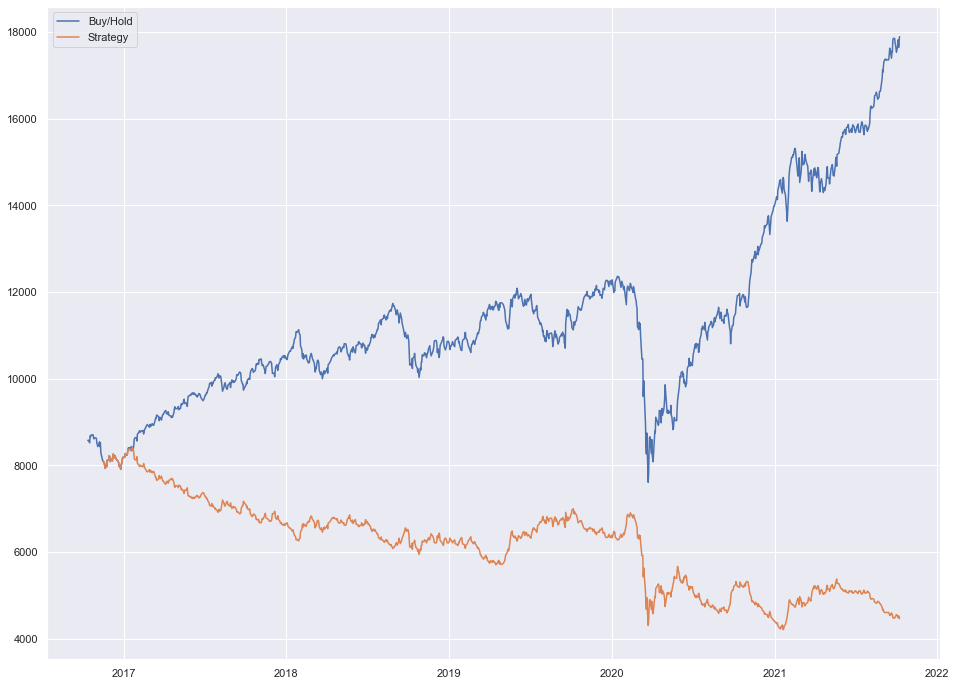

In [16]:
plt.plot(df['Close'], label='Buy/Hold')
plt.plot(df['returns(strategy)'], label='Strategy')
plt.legend();

In [17]:
buyhold=(Close[len(Close)-1]-Close[0]) / Close[0]
print("Buy/Hold return : ", buyhold*100 , "%")

Close1=df['returns(strategy)']

strat=(Close1[len(Close1)-1]-Close1[loc]) / Close1[loc]
print("Strategy return : ", strat*100 , "%")

Buy/Hold return :  108.73054330108633 %
Strategy return :  -44.97897365181963 %


In [18]:
#Strategy fail